# BART Webinar: A deep dive into 3D Cartesian reconstruction with BART

This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to work with 3D Cartesian data using BART, with the goal of implementing a full processing pipeline from raw data to reconstructed image.


## Outline
1. Bart Setup
1. 3D data explortation
1. 3D preprocessing
1. 3D reconstruction
1. 3D postprocessing


**Author**: [Jon Tamir](mailto:jtamir@utexas.edu)

**Institution**: University of Texas at Austin

Based on previous material written by [Moritz Blumenthal](mailto:blumenthal@@tugraz.at) and [H. Christian M. Holme](mailto:Holme@tugraz.at)


## 1 Setup BART
This notebook is designed to run on a local system and on Google Colab. It uses the python kernel, however, almost all commands use the `%%bash` cell magic to be executed in a `bash` subshell.

We will use BART version 0.9.00. In particular, we will take advantage of the newly added looping feature. For more information check the announcement on our [mailing list](https://lists.eecs.berkeley.edu/sympa/arc/mrirecon/2023-12/msg00000.html).


This version has been archived at CERN as:  

BART: version 0.9.00 (2023) DOI:10.5281/zenodo.10277939

### 1.1 Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart)
- Set the `TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export BART_TOOLBOX_PATH=/path/to/bart  
export PATH=$BART_TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is from a terminal, there are also wrapper functions that allow the tools to be used from Matlab and Python. These are located under the `$BART_TOOLBOX_PATH/matlab` and `$BART_TOOLBOX_PATH/python` directories.

We will also use the [CFL viewer](https://github.com/mrirecon/view). Install it locally after configuring BART

### 1.2 Clone and compile BART v0.9.00
We clone BART into the current working directory of this notebook and delete any previous installation in this directory.

In [1]:
%%bash

# Clone Bart
[ -d bart ] && rm -r bart
git clone https://github.com/mrirecon/bart/ --branch v0.9.00 bart &> /dev/null

cd bart

# Define compile options
# COMPILE_SPECS=" PARALLEL=1
#                 PARALLEL_NJOBS=16
#                 CUDA=0
#                 "

# printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local


make -j16 &> /dev/null

### 1.3 Add BART to PATH variable

We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [2]:
import os
import sys

os.environ['BART_TOOLBOX_PATH']=os.getcwd()+"/bart/"
os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")
os.environ['DEBUG_LEVEL'] = '2'

Check BART setup:

In [3]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/home/jon/dev/bart-webinars/webinar8/bart//bart
# BART version: 
v0.9.00


### 1.4 Install Interactive CFL Viewer


In [5]:
%%bash

# Clone Bart
[ -d view ] && rm -r view
git clone https://github.com/mrirecon/view/ view &> /dev/null

cd view

make &> /dev/null

In [6]:
os.environ['VIEW_TOOLBOX_PATH']=os.getcwd()+"/view/"
os.environ['PATH'] = os.environ['VIEW_TOOLBOX_PATH'] + ":" + os.environ['PATH']

Check view setup:

In [7]:
%%bash

echo "# The BART used in this notebook:"
which view

# The BART used in this notebook:
/home/jon/dev/bart-webinars/webinar8/view//view


### 1.5 Python visualizer

In [16]:
# More python libraries
import cfl
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

def bart_plot(data, from_cfl=False, title=None, vmin=None, vmax=None, cmap='gray', cbar_label='', mag=True, fsize=10):

    # Import data
    if from_cfl:
        data = cfl.readcfl(data).squeeze()
    data = np.abs(data) if mag else data

    fig = plt.figure(figsize=(fsize,fsize))
    ax1 = fig.add_subplot(111)
    im = ax1.imshow(data, interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    if title:
      plt.title(title)
    # Style settings
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cbar_label)
    cbar.ax.tick_params()

    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    ax1.set_axis_off()


    plt.show()

## 2. 3D Cartesian pre-processing

For this tutorial, we will go over the steps involved in reconstructing 3D Cartesian data.

Data were scanned on a 3T 750W scanner (GE Healthcare) using a 12-channel head coil. The data were collected with partial Fourier sampling of 75\% in the phase encode direction using the BRAVO sequence. The parallel imaging acceleration factor was 1.75x1.25.

Our goal is to do a fully 3D reconstruction taking advantage of steps that can be split into separate 2D problems. Some steps will naturally require 3D operations.

Because the BART file format is simple, it is possible to read data from many different sources. The BART command includes the `twixread` tool for basic reading of Siemens `.dat` files. We also include GE Orchestra libraries for reading P-File and ScanArchives, called [ox-bart](https://github.com/mrirecon/ox-bart).

In this part, we have already converted a k-space dataset from the vendor-specific format to BART format. The files are the following:

- `ksp`: Raw k-space data
- `noise`: Noise pre-scan

We will use use both reconstruction

### A note on working with 3D data

Because of the complexity of 3D data (+ coils), we will want to view the data with a 3D viewer. For this reason, I will use the [BART View Tool](https://github.com/mrirecon/view). This viewer will pop up a new window on my machine. For this reason, it will not be usable directly in Colab. Therefore, in Colab we will skip these cells and instead plot a single slice for demonstration purposes.

Now, we will often manipulate the data in different ways: perform FFTs, RSS the coil dimension, look at sampling patterns, etc. This means that we will create lots of temporary BART files that may not be needed after a while. When you are working on a machine with a large hard disk, my recommendation is to keep the temporary files until you are ready to write a final, clean script. This leaves a "paper trail" for debugging. But if you are low on space, you can delete the files as you go.

### 2.1 Explore the data and correct orientation

In [9]:
%%bash

echo "ksp:"
bart show -m data/ksp_raw
echo
echo "noise:"
bart show -m data/noise

ksp:
Type: complex float
Dimensions: 16
AoD:	240	180	182	12	1	1	1	1	1	1	1	1	1	1	1	1

noise:
Type: complex float
Dimensions: 16
AoD:	4096	1	1	12	1	1	1	1	1	1	1	1	1	1	1	1


Based on the array sizes and dimensions, we can infer that the readout dimension is 240 samples, the phase encode dimension is 180, the slice encode is 182, and there are 12 coils. Notice that the phase encode dimension is 75\% of the readout dimension, consistent with the Partial Fourier factor.

When working with new data, it is useful to plot it to get a sense of what is going on.
Let's print the middle slice on the first coil in the three principal directions.

In [10]:
%%bash

view data/ksp_raw

It looks like our k-space data are not centered due to the Partial Fourier factor. This means we will need to zero-pad the data in order to get it to the correct size.

Before that, let's take a look at the data in the image domain

In [12]:
%%bash
bart fft -iu 7 data/ksp_raw cimg_raw

In [ ]:
%%bash
view cimg_raw

There are two "problems."
1. The image is flipped in the readout direction! Let's unflip it to keep things consistent
2. There is a FOV/2 shift in the slice encode direction. This is common with 3D GE data. Let's correct it

In [14]:
%%bash

bart flip 1 data/ksp_raw ksp0
bart fftmod $(bart bitmask 2) ksp0 ksp

bart fft -iu 7 ksp cimg

In [ ]:
%%bash

view cimg

That's better!

### 2.2 Noise prewhitening
Modern scanner software versions will provide us with a noise pre-scan. In this case, we have the noise array, which contains 4096 readout samples for each coil. We can use this array to build a noise prewhitening matrix and apply it to the data. Let's look at the original noise covariance matrix of the data using the `bart whiten` tool.

```bash
Usage: whiten [-o <file>] [-c <file>] [-n] <input> <ndata> <output> [<optmat_out>] [<covar_out>] 

Apply multi-channel noise pre-whitening on <input> using noise data <ndata>.
Optionally output whitening matrix and noise covariance matrix

-o <optmat_in>    use external whitening matrix <optmat_in>
-c <covar_in>     use external noise covariance matrix <covar_in>
-n                normalize variance to 1 using noise data <ndata>
-h                help
```

In [15]:
%%bash
bart whiten ksp data/noise ksp_white optmat covar

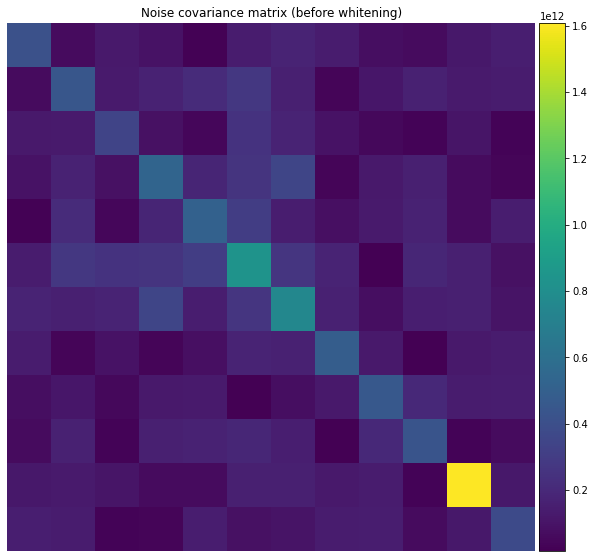

In [17]:
bart_plot('covar', from_cfl=True, cmap='viridis', title='Noise covariance matrix (before whitening)')

There is a higher amount of noise in the second-to-last channel. Without noise pre-whitening, we will unnecessarily amplify the noise in the reconstruction due to that channel. Effectively, noise pre-whitening lowers the contribution of that noisy channel while also decorrelating the noise across channels.

We will continue processing the data, but now working off of the `ksp_white` file

### 2.4 Zero-pad by the Partial Fourier factor
As we saw earlier, the kspace data were not centered because of the PF factor. Let's go ahead and zero-padd by the factor.

We will continue to do all our operations using bash so that at the end we can turn it into a usable script

In [18]:
%%bash

dim0=$(bart show -d 0 ksp)
echo $dim0

bart resize 1 $dim0 ksp_white ksp_white_resize

bart show -m ksp_white_resize

240
Type: complex float
Dimensions: 16
AoD:	240	240	182	12	1	1	1	1	1	1	1	1	1	1	1	1


### 2.4 Coil Compression
To reduce the size of our dataset and therefore also decrease the computational complexity, we perform a coil compression with the `cc` command using the [Geometric Coil Compress (GCC)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3396763/) approach.

We will do coil compression in 2 steps. We will first use `cc` on the kspace data to create the coil compression matrix. We will then use ``ccapply` to apply it to both the reference data and to the k-space data. This way we use the same coil compression matrix for both arrays.

We compress reduce the dataset to 6 virtual coils with `-p`.


In [19]:
%%bash
bart cc -h
bart ccapply -h

Usage: cc [-p d] [-M] [-r d:d:d] [-A] [-S] [-G] [-E] <kspace> <coeff|proj_kspace> 

Performs coil compression.

-p N    perform compression to N virtual channels
-M      output compression matrix
-r S    size of calibration region
-A      use all data to compute coefficients
-S      type: SVD
-G      type: Geometric
-E      type: ESPIRiT
-h      help
Usage: ccapply [-p d] [-u] [-t] [-S] [-G] [-E] <kspace> <cc_matrix> <proj_kspace> 

Apply coil compression forward/inverse operation.

-p N    perform compression to N virtual channels
-u      apply inverse operation
-t      don't apply FFT in readout
-S      type: SVD
-G      type: Geometric
-E      type: ESPIRiT
-h      help


In [20]:
%%bash
bart cc -M -G ksp_white_resize cc_mat
bart ccapply -G -p 6 ksp_white_resize cc_mat ksp_white_resize_cc

bart show -m ksp_white_resize_cc

Done.
Done.
Type: complex float
Dimensions: 16
AoD:	240	240	182	6	1	1	1	1	1	1	1	1	1	1	1	1


### 2.6 RSS reconstructions

The data were acquired with a modest acceleration factor of `1.25 x 1.75`.  
Let's do simple RSS reconstructions of the subsampled data to get a sense of it

In [21]:
%%bash

bart fft -iu 7 ksp_white_resize_cc cimg_white_resize_cc
bart rss $(bart bitmask 3) cimg_white_resize_cc reco_rss

In [22]:
%%bash

view reco_rss

The result is not very good. The image is corrupted with aliasing artifacts due to the equispaced subsampling. There is also a slight blur in the phase encode direction due to the Partial Fourier sampling.

Moving on!

### 2.7 Coil Sensitivity Estimation

We use the ESPIRiT algorithm to obtain the coil sensitivity profiles. We will now take a closer look at the ESPIRiT `ecalib` tool.

In [ ]:
%%bash
bart ecalib -h

The default number of maps is 2. It's often a good idea to use 2 maps for reconstruction of clinical data, as it's possible that there are slight inconsistencies either due to the scan prescription or motion.

Notice that the ecalib tool has a `-1` option. ESPIRiT has two disctinct steps:
1. Estimate the signal/noise subspaces by performing an SVD of the calibration matrix derived from the ACS region
1. Estimate the eigenvectors/eigenvalues by performing EVD on a per-pixel basis; these form the sensitivity maps

Step 1 requires the full ACS region. Step 2 is "embarassingly parallel", meaning that each pixel (or slice) can be computed separately.

Now, if we plan to use a single machine for reconstruction, it is not too important to split these steps. Just run `ecalib` and both steps will be performed. Step 1 will use all the available CPU cores to perform the SVD. Step 2 will distribute the EVD on a slice-by-slice basis.

In [ ]:
%%bash

bart ecalib -1 ksp_white_resize_cc calone
bart show -m calone

In [ ]:
%%bash

dim0=$(bart show -d 0 ksp_white_resize_cc)
dim1=$(bart show -d 1 ksp_white_resize_cc)
dim2=$(bart show -d 2 ksp_white_resize_cc)
bart ecaltwo -m2 $dim0 $dim1 $dim2 calone sens

In [ ]:
%%bash

view sens

## 3 Parallel imaging reconstruction
We are now ready to do a parallel imaging reconstruction. 

Given the sensitivities, we can use the `pics` command to perform iterative parallel imaging reconstruction using various regularization terms. It solves the folllowing minimization problem:

$\arg\min_x ||PFS x - y|| + \lambda R(x)$, where:
- $P$ is the sampling operator
- $F$ is the Fourier transform
- $S$ is the multiplication with the sensitivity maps
- $x$ is the unknown image
- $y$ are the acquired multi-coil k-space data
- $R$ is a regularization functional
- $\lambda$ is the regularization weighting parameter

A popular regularization is $\ell_2$, i.e. $R(x) = ||x||_2^2$.

The objective function then corresponds to a SENSE reconstruction. We will use `pics` with l2 regularization.

In [ ]:
%%bash
bart pics -h

bart pics -Rh

### 3.1 Slice-by-slice PICS

Now, because the data are 3D Cartesian, the data are fully sampled in the readout direction. This means that there is only a small benefit to performing a full 3D reconstruction, at the cost of computation time.

Instead, we will perform PICS reconstruction in a slice-by-slice manner. The steps we will take are the following:
1. Perform an IFFT in the readout direction to decouple the readout slices
1. Perform a PICS reconstruction of each slice independently (in parallel)
1. Rejoin the data

Fortunately, Steps 2-3 can now be automated using BART v0.9.00's new looping feature.

There is one caveat: PICS will automatically scale the data to roughly the range [0, 1], so that the regularization parameter can be chosen in a similar range for different datasets. If we reconstruct each slice separately, the scale factor will differ.

To have a relatively consistent regularization, we will want to scale each slice by the same scale factor. We will run one iteration of 3D pics to get the scale factor

In [ ]:
%%bash

bart fft -iu 1 ksp_white_resize_cc ksp_white_resize_cc_fft

In [ ]:
%%bash

scale_factor=$(bart pics -d4 -i 0 ksp_white_resize_cc sens reco_l2 | grep Scaling |  awk  '{print $2}')
export scale_factor=${scale_factor::-1}
echo "Reconstruction scale factor: $scale_factor"

lambda=.0015
debug_level=0

view reco_l2 &

OMP_NUM_THREADS=1 bart --loop 1 -r ksp_white_resize_cc_fft -t 80 \
    pics -w ${scale_factor} -S -l2 r ${lambda} -d ${debug_level} \
        ksp_white_resize_cc_fft sens reco_l2

## 4. Post-processing

The reconstruction looks pretty good! However, you may notice that it is a little blurry in the phase encode direction due to the PF factor.

There is also a second image because we reconstructed with two maps. There is no "right answer" for dealing with the second map, as it can be quite application-dependent. We will choose to combine the second map by going through the coil operator, and then perform homodyne correction on each channel indepdently. Finally, we will coil-combine with an RSS operation.

For the last step, we will perform homodyne correction

In [ ]:
%%bash

bart fmac -s $(bart bitmask 4) reco_l2 sens reco_l2_cimg
bart show -m reco_l2_cimg

In [ ]:
%%bash
bart homodyne -h

The homodyne command can take optional arguments like a phase reference and an offset ramp filter. It can also save some operations if the data are already Fourier transformed or uncentered.

In [ ]:
%%bash
bart homodyne -I 1 0.75 reco_l2_cimg reco_l2_cimg_homodyne
bart rss 8 reco_l2_cimg_homodyne reco_l2_homodyne

In [ ]:
%%bash
view reco_l2_homodyne &
view reco_l2 

__Thank you for attending!__